#전이모델을 이용한 이미지 분류 
- 전이 학습의 주요 시나리오 
    - 합성곱 신경망의 미세조정 
    - 고정된 특징 추출기로써의 합성곱 신경망 

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

# 데이터 로드 

In [ ]:
!gdown https://drive.google.com/uc?id=1izmWdUcLrnnAImB34Lo6C7rKuWnvXi-o&export=download
!mkdir data
%cd data 
!unzip /content/hymenoptera_data.zip

In [6]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
%cd /content/
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 이미지 시각화 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


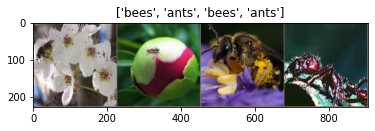

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 모델 - 파인 튜닝 

## 모델 정의 

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features #<-- model_ft의 fc레이어의 input features수 
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2) #<--- 원래 마지막 레이어가 512->1000으로 되있는걸 512->2로 바꿈 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 모델 학습 모듈 

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

## 모델 예측 시각화 

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 모델 학습 및  평가 

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6789 Acc: 0.6926
val Loss: 0.6546 Acc: 0.7843

Epoch 1/24
----------
train Loss: 0.6495 Acc: 0.7500
val Loss: 0.3093 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5103 Acc: 0.7582
val Loss: 0.2680 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4388 Acc: 0.8279
val Loss: 0.3315 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4828 Acc: 0.8074
val Loss: 0.2123 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4060 Acc: 0.8361
val Loss: 0.2807 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.6765 Acc: 0.7377
val Loss: 0.3139 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.4375 Acc: 0.8197
val Loss: 0.2548 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3515 Acc: 0.8361
val Loss: 0.2287 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3231 Acc: 0.8607
val Loss: 0.2193 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2882 Acc: 0.8811
val Loss: 0.1700 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2989 Acc: 0.8811
val Loss: 0.1633 Acc: 0.9412

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


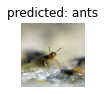

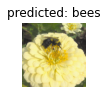

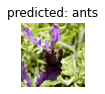

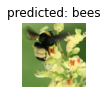

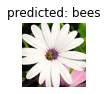

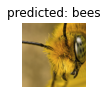

In [22]:
visualize_model(model_ft)

# 모델 - 고정된 특징 추출기 
- requires_grad = False로 설정해 매개변수 고정 
- backward() 중에 경사도 계산되지 않도록 고정 

In [25]:
model_conv = torchvision.models.resnet18(pretrained=True)

#로드한 model_conv의 각 파라미터 모두 경사 계산 off 
for param in model_conv.parameters():
  param.requires_grad = False 

#이 다음에 새로 생성한 매개변수에서만 경사 계산 됨 
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2) #마지막 fc 레이어만 새로 선언함 <- 이건 경사 계산 됨 

model_conv = model_conv.to(device)

loss_fn = nn.CrossEntropyLoss() 

#이전과는 다르게 마지막 계층의 매개변수들만 최적화 되는지 관찰 
optimizer_conv = optim.SGD(model_conv.fc.parameters(),lr=1e-3,momentum=0.9)

#7에폭 마다 0.1씩 학습률 감소 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 학습 및 평가 

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6015 Acc: 0.6680
val Loss: 0.2203 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4208 Acc: 0.7992
val Loss: 0.1967 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.2939 Acc: 0.8893
val Loss: 0.1755 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5509 Acc: 0.7787
val Loss: 0.2055 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4401 Acc: 0.8197
val Loss: 0.2591 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5529 Acc: 0.7705
val Loss: 0.2084 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3852 Acc: 0.8279
val Loss: 0.1712 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3281 Acc: 0.8402
val Loss: 0.2332 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3418 Acc: 0.8402
val Loss: 0.1898 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2258 Acc: 0.9180
val Loss: 0.2009 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.4199 Acc: 0.8279
val Loss: 0.1916 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2970 Acc: 0.8607
val Loss: 0.2090 Acc: 0.9216

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


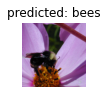

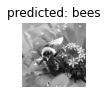

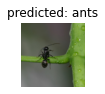

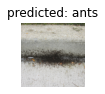

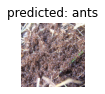

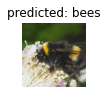

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#모델 - 전이모델 + 추가 레이어 

In [39]:
class newmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.transfer = torchvision.models.resnet18(pretrained=True)
    self.transfer_output = self.transfer.fc.out_features
    self.conv = nn.Conv2d(self.transfer_output,512,3,1,padding='same')
    self.fc = nn.Linear(512,10)

  def forward(self,x):
    x = self.transfer(x)
    x = nn.MaxPool2d(self.conv(x))
    x = self.fc(x)
    return x 
model = newmodel()
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


newmodel(
  (transfer): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r